In [6]:
NOVA_HOME = '/home/projects/hornsteinlab/Collaboration/NOVA_GAL/NOVA'

In [7]:
import os
import sys
import numpy as np
import cv2 
import pandas as pd
%matplotlib inline

os.environ['NOVA_HOME'] = NOVA_HOME

sys.path.insert(1, os.getenv('NOVA_HOME'))
print(f"NOVA_HOME: {os.getenv('NOVA_HOME')}")


from src.preprocessing.preprocessing_utils import rescale_intensity, fit_image_shape, get_image_focus_quality
from tools.preprocessing_tools.image_sampling_utils import sample_raw_images
from tools.preprocessing_tools.eval_preprocessing_steps_utils import get_processed_images, plot_images, test_cellpose
%load_ext autoreload
%autoreload 2

NOVA_HOME: /home/projects/hornsteinlab/Collaboration/NOVA_GAL/NOVA


In [ ]:
INPUT_DIR_BATCH = "/home/projects/hornsteinlab/Collaboration/NOVA/input/images/raw/John/iAstrocytes/ordered/batch1/"
brenner_csv_path = "/home/projects/hornsteinlab/Collaboration/NOVA_GAL/NOVA/manuscript/markers_focus_boundries/markers_focus_boundries_iAstrocytes.csv"
INPUT_DIR_BATCH_PROCESSED = "/home/projects/hornsteinlab/Collaboration/MOmaps/input/images/processed/iAstrocytes/"

EXPECTED_SITE_WIDTH, EXPECTED_SITE_HEIGHT = 1024, 1024

sample_size = 20
rep = 'rep2'
marker = 'DAPI'
condition = 'Untreated'
cell_line = 'WT'
panel = 'panelA'

In [5]:
images_paths = sample_raw_images(INPUT_DIR_BATCH, marker,
                                 cell_line=cell_line, condition=condition, sample_size=sample_size, rep=rep, panel=panel)
# images_paths = sample_images_all_markers_all_lines(input_dir_batch=INPUT_DIR_BATCH, _sample_size_per_markers=5, _num_markers=26, 
#                                         raw=True, all_conds=True, rep_count=2, cond_count=2, exclude_DAPI=False, markers_to_include=None)
# images_paths = random.sample(images_paths, len(images_paths))
images_paths

FileNotFoundError: [Errno 2] No such file or directory: '/home/projects/hornsteinlab/Collaboration/MOmaps/input/images/raw/SpinningDisk/NOVA_d18_neurons_sorted/batch2/TDP--43-G348V-1057052/panelF/stress/rep2/DAPI'

In [ ]:
images = []
for p in images_paths:
    image = cv2.imread(p, cv2.IMREAD_ANYDEPTH)
    images.append(image)
    
images = np.stack(images, axis=0)
images.shape

In [ ]:
images_paths

In [ ]:
plot_images(images, images_paths)

In [ ]:
images_processed = np.zeros((images.shape[0], EXPECTED_SITE_WIDTH, EXPECTED_SITE_HEIGHT))
images_paths_processed = images_paths.copy()

# Handle size

In [ ]:
for i in range(len(images)):
    images_processed[i] = fit_image_shape(images[i], (EXPECTED_SITE_WIDTH, EXPECTED_SITE_HEIGHT))

In [ ]:
plot_images(images_processed, images_paths_processed, 3)

# Rescale Intensity

In [ ]:
# Apply rescale intensity
for i in range(len(images_processed)):
    images_processed[i] = rescale_intensity(images_processed[i], lower_bound = 1)

In [ ]:
plot_images(images_processed, images_paths_processed, 3, figsize=(35,10))

# Brenner

In [ ]:
brenner_cutoffs = pd.read_csv(brenner_csv_path, index_col=0)
brenner_cutoffs

brenner_marker = brenner_cutoffs.loc[marker]
brenner_lower_bound, brenner_upper_bound = brenner_marker[0], brenner_marker[1]

In [ ]:
brenner_for_sampled_images = []
n_samples = 3

for i in range(len(images_processed)):
    brenner_for_sampled_images.append(get_image_focus_quality(images_processed[i]))
brenner_for_sampled_images = np.asarray(brenner_for_sampled_images)

# Show images passed filter
passed_images_indexes = np.argwhere((brenner_for_sampled_images >= brenner_lower_bound) & (brenner_for_sampled_images <= brenner_upper_bound)).reshape(-1)
if len(passed_images_indexes) > 0:
    plot_images(images_processed[passed_images_indexes], images_paths_processed[passed_images_indexes], n_samples=min(n_samples, len(passed_images_indexes)), suptitle='Valid')
else:
    print("No valid files (in terms of Brenner)")

# Show images failed filter
failed_images_indexes = list(set(np.arange(len(images_processed))) - set(passed_images_indexes))
if len(failed_images_indexes) > 0:
    plot_images(images_processed[failed_images_indexes], images_paths_processed[failed_images_indexes], n_samples=min(n_samples, len(failed_images_indexes)), suptitle='Invalid')
else:
    print("All files are valid (in terms of Brenner)")

images_processed = images_processed[passed_images_indexes]
images_paths_processed = images_paths_processed[passed_images_indexes]


# Cellpose

In [ ]:
# Apply cellpose on remaining images
# NOTE! Use only with marker was set to DAPI!
test_cellpose(images_processed, images_paths_processed, flow_threshold=0.4, cellprob_threshold=0, diameter=60,
             add_grid=True)

# Processed images

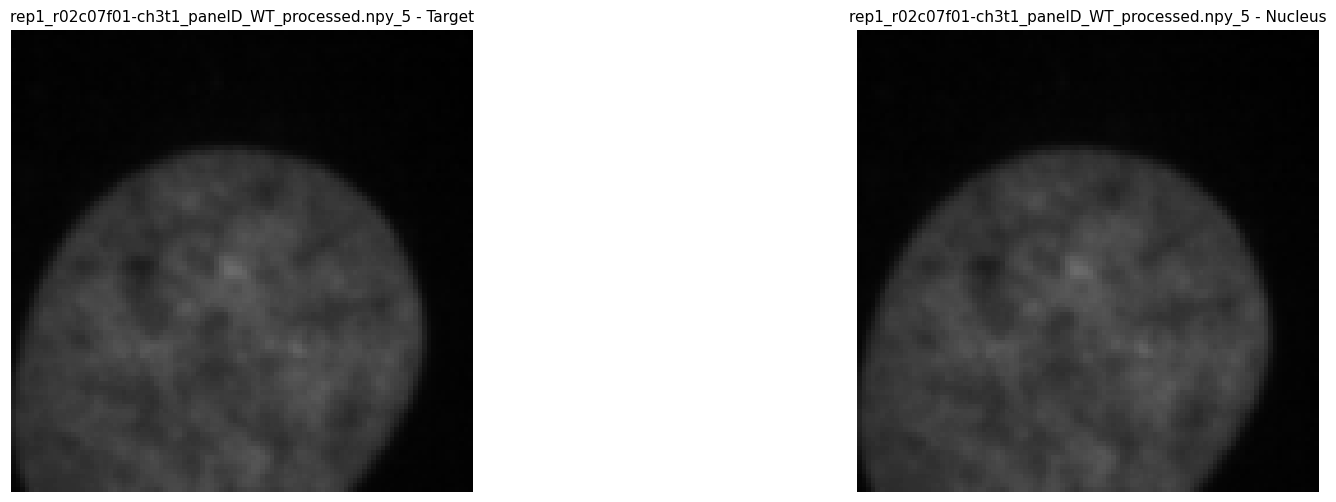

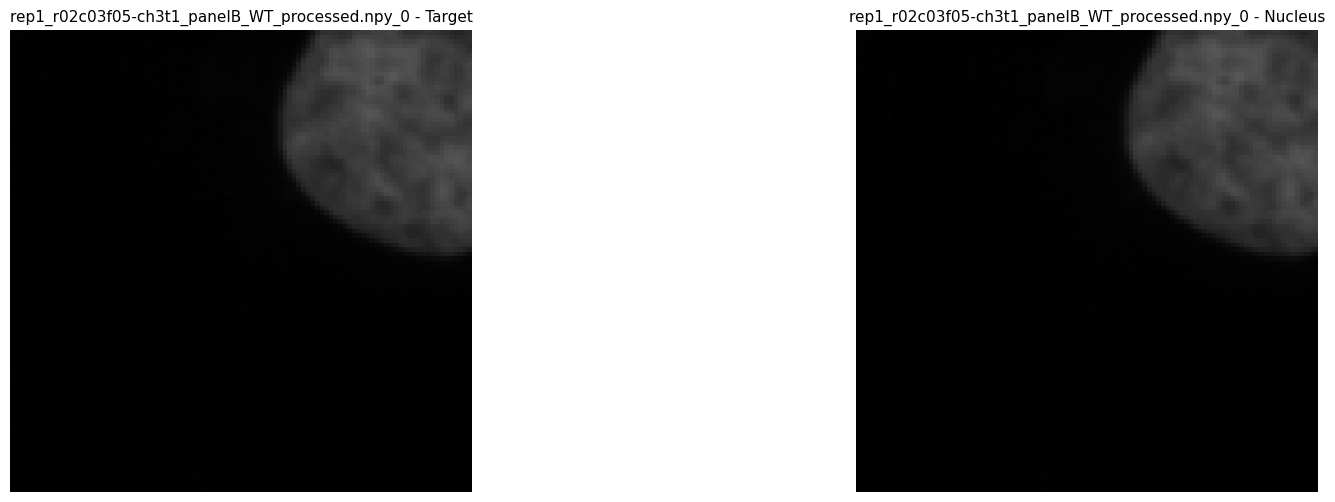

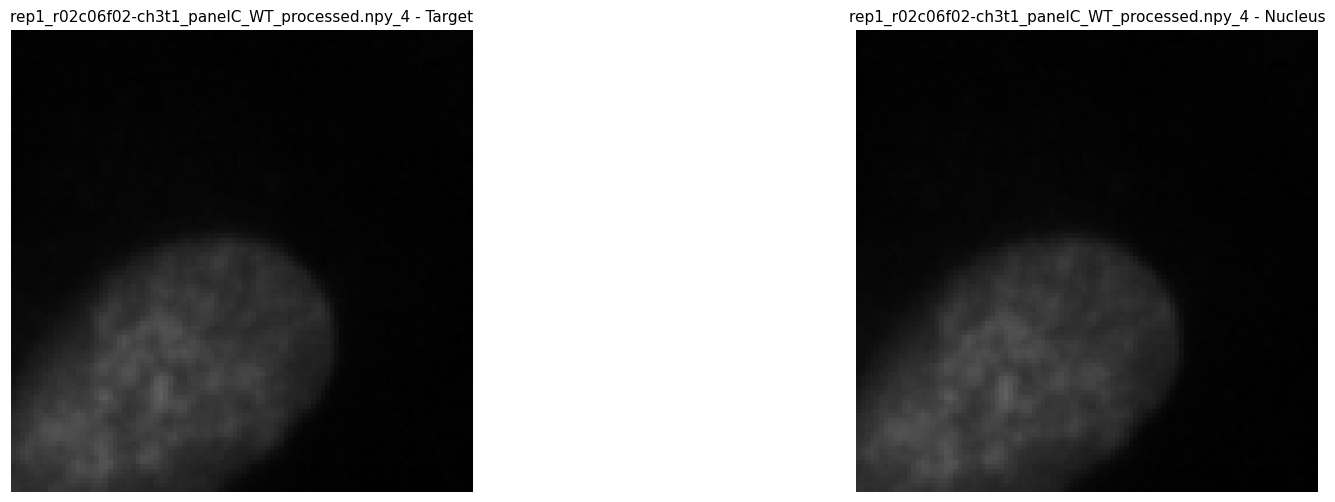

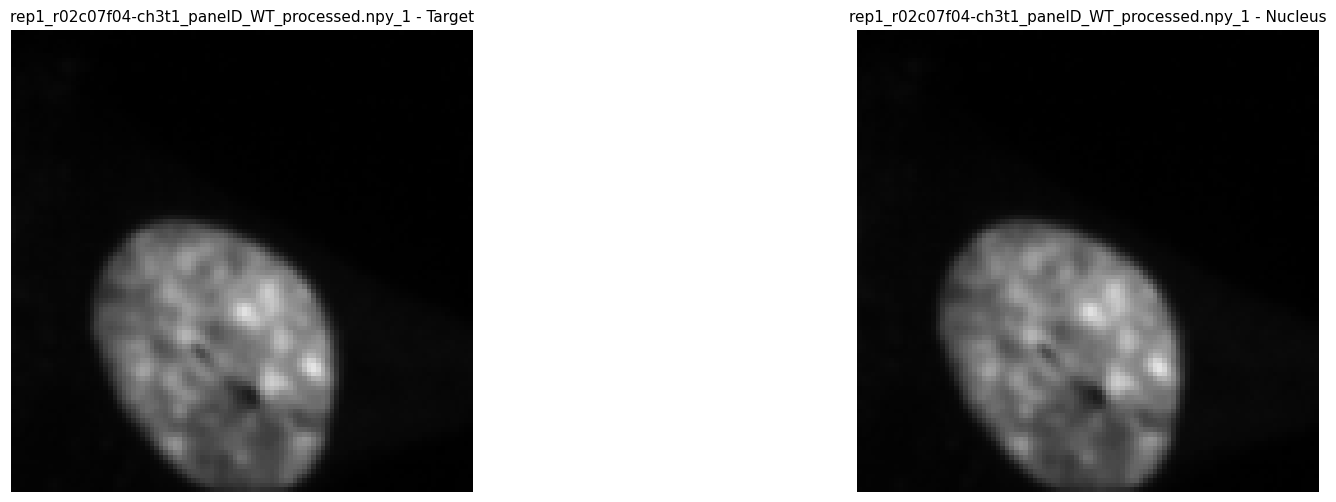

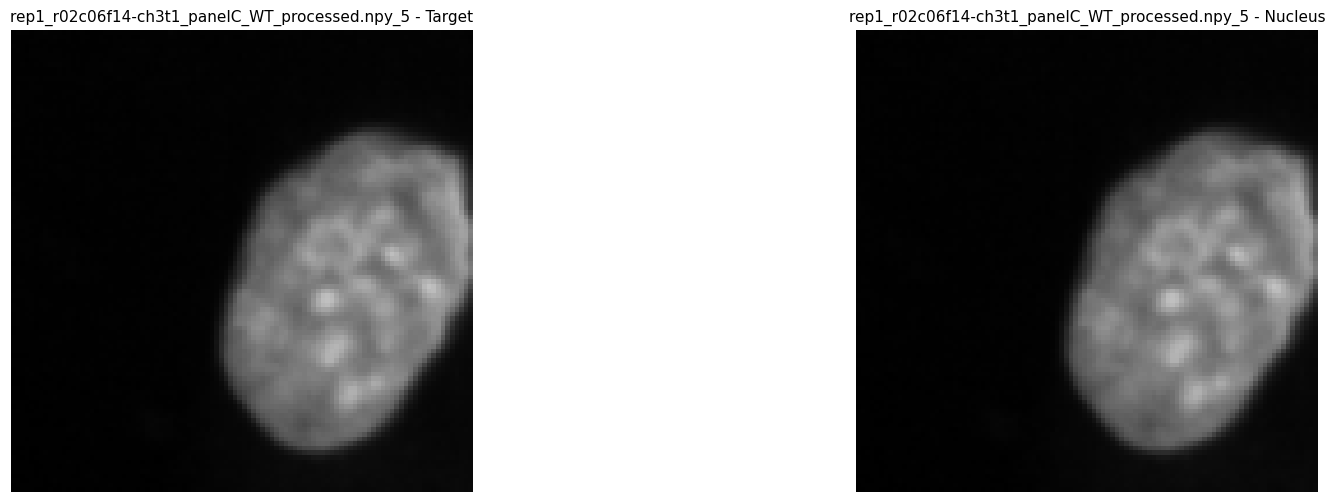

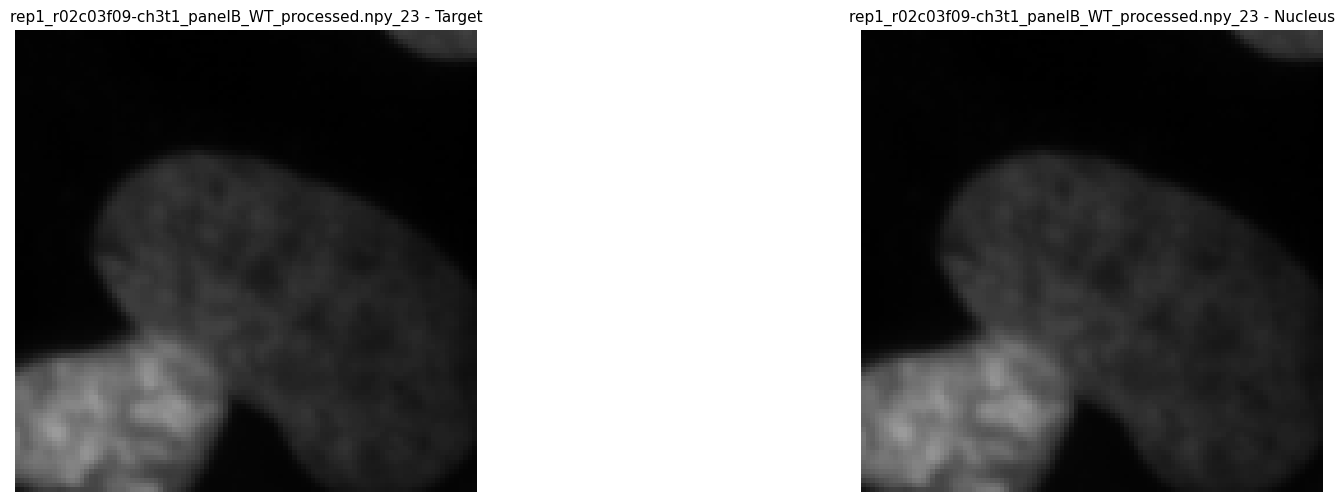

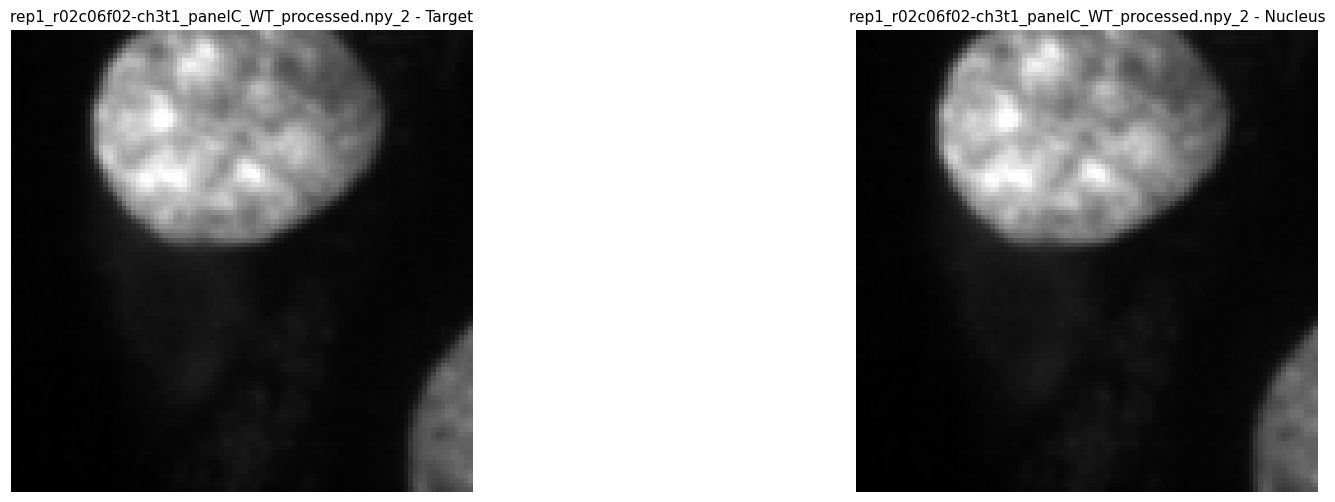

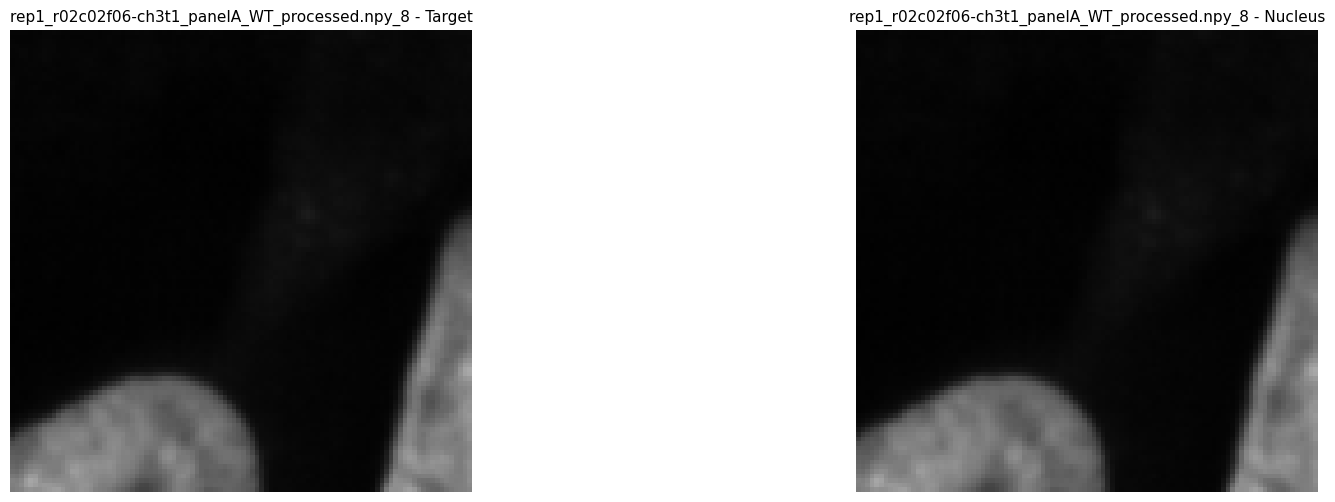

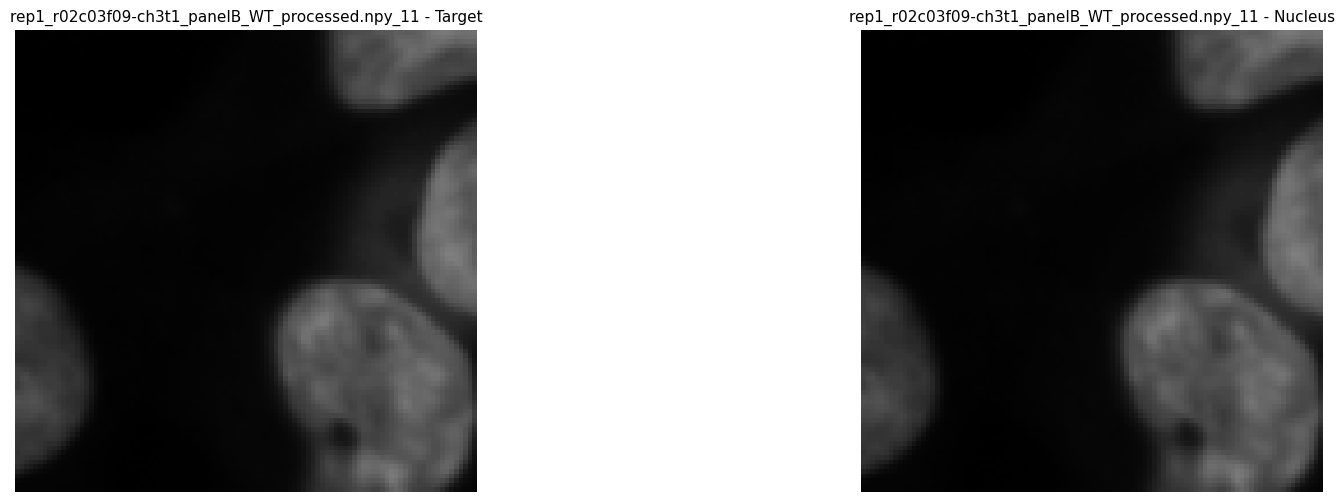

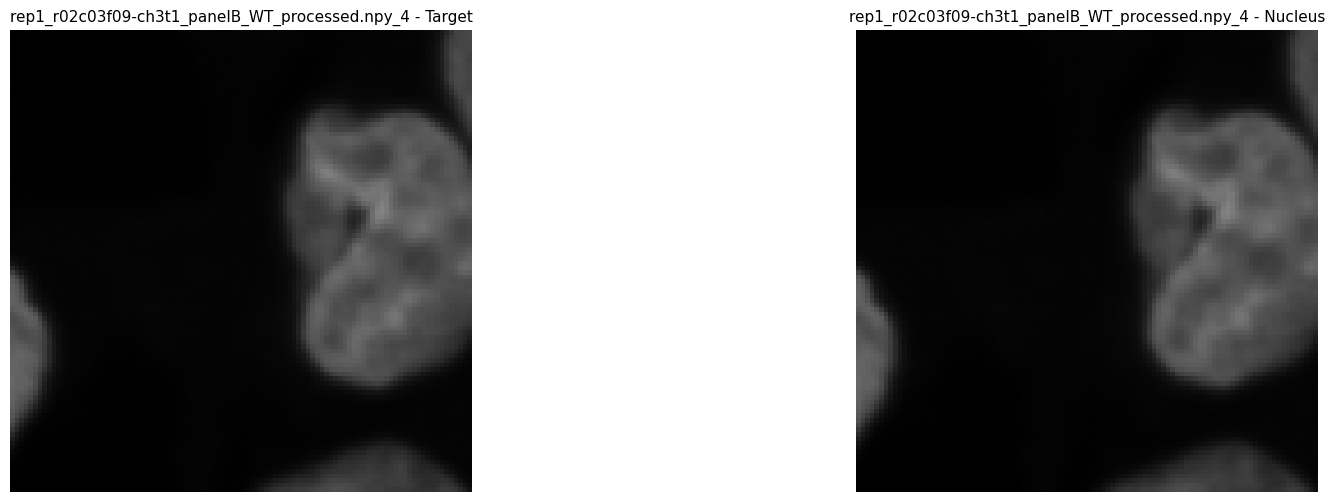

In [11]:
# figsize=(20,6)
# sample_size = 5
# marker='FUS'
# cell_line='WT'
# condition='Untreated'
# rep='rep1'

_ = get_processed_images(INPUT_DIR_BATCH_PROCESSED, sample_size=sample_size, marker=marker, cell_line=cell_line, condition=condition, rep=rep, figsize=figsize)